In [1]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
import json
from matplotlib.pyplot import cm

In [2]:
def distance(a, b):
    d = a - b
    return np.sqrt(d[0]**2+d[1]**2+d[2]**2)

In [3]:
#with open("RRT_data3.json", "r") as read_file:
with open("RRTstar_data2.json", "r") as read_file:
    decodedArray = json.load(read_file)

    V = np.asarray(decodedArray["V"])
    E = np.asarray(decodedArray["E"])
    T = np.asarray(decodedArray["T"])
    Cost = np.asarray(decodedArray["Cost"])
    Parent = np.asarray(decodedArray["Parent"])
    WaitTime = np.asarray(decodedArray["Wait"])

In [4]:
import numpy as np

# Camera Model
class Camera:
    def __init__(self, cam_pos, R, thetaH, thetaV, pan, tilt):
        self.cam_position = cam_pos[0:3]    # [x, y, z], intial position at t0
        self.cam_orientation = cam_pos[3:5] # [pan, tilt], initial position at t0
        self.R = R
        self.pan = pan                      # [min, max, angular rate]
        self.tilt = tilt                    # [min, max, angular rate]
        self.thetaH = thetaH
        self.thetaV = thetaV

    def get_pos(self):
        return self.cam_position
    
    def get_h(self):
        return self.R

    def R1(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
    
    def R2(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
    
    def R3(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    
    def get_current_pan(self, timeInstance):
        return self.cam_orientation[0] + self.pan[2]*timeInstance

    def get_current_tilt(self, timeInstance):
        return self.cam_orientation[1] + self.tilt[2]*timeInstance

    def get_direc(self, timeInstance):
        R = self.R
        direc_vec = np.array([[R], [0], [0]])

        # Assume Camera in xyz Frame
        panmin = self.pan[0]
        panmax = self.pan[1]
        panRate = self.pan[2]
        tiltmin = self.tilt[0]
        tiltmax = self.tilt[1]
        tiltRate = self.tilt[2]
        translate = self.cam_position

        # Pan angle from 0 to 360
        currPan = self.get_current_pan(timeInstance)
        if currPan > panmax:
            currPan = panmax - np.mod(currPan, panmax)
        elif currPan < panmin:
            currPan = np.mod(currPan, panmin) + panmin

        # Tilt angle from 0 to -90
        currTilt = self.get_current_tilt(timeInstance)
        if currTilt > tiltmax:
            currTilt = tiltmax - np.mod(currTilt, tiltmax)
        elif currTilt < tiltmin:
            currTilt = np.mod(currTilt, tiltmin) + tiltmin

        # Translate FOV at given timeInstance
        direc_vec = self.R3(currPan)@self.R2(currTilt)@direc_vec + np.array([[translate[0]], [translate[1]], [translate[2]]])
        return np.hstack([np.array([[translate[0]], [translate[1]], [translate[2]]]), direc_vec])

        
    def get_vertex(self, timeInstance):
        R = self.R
        thH = self.thetaH
        thV = self.thetaV

        # Compute 4 corner of FOV at given time
        vertexFOV = {}
        vertexFOV['0'] = np.array([[R], [-R*np.tan(thH/2)], [R*np.sin(thV/2)]])
        vertexFOV['1'] = np.array([[R], [-R*np.tan(thH/2)], [-R*np.sin(thV/2)]])
        vertexFOV['2'] = np.array([[R], [R*np.tan(thH/2)], [-R*np.sin(thV/2)]])
        vertexFOV['3'] = np.array([[R], [R*np.tan(thH/2)], [R*np.sin(thV/2)]])
        
        # Assume Camera in xyz Frame
        panmin = self.pan[0]
        panmax = self.pan[1]
        panRate = self.pan[2]
        tiltmin = self.tilt[0]
        tiltmax = self.tilt[1]
        tiltRate = self.tilt[2]
        translate = self.cam_position

        # Pan angle from 0 to 360
        currPan = self.cam_orientation[0] + panRate*timeInstance
        if currPan > panmax:
            currPan = panmax - np.mod(currPan, panmax)
        elif currPan < panmin:
            currPan = np.mod(currPan, panmin) + panmin

        # Tilt angle from 0 to -90
        currTilt = self.cam_orientation[1] + tiltRate*timeInstance
        if currTilt > tiltmax:
            currTilt = tiltmax - np.mod(currTilt, tiltmax)
        elif currTilt < tiltmin:
            currTilt = np.mod(currTilt, tiltmin) + tiltmin

        # Translate FOV at given timeInstance
        for i in range(4):
            vertexFOV[str(i)] = self.R3(currPan)@self.R2(currTilt)@vertexFOV[str(i)] + np.array([[translate[0]], [translate[1]], [translate[2]]])
        
        return vertexFOV

In [5]:
# Map
map_size = np.array([0, 25, 0, 25, 0, 10]) # min, max

# Building 0
building0 = {}
building0['Polygon'] = [(1*2.5,4*2.5), (6.5*2.5,4*2.5), (6.5*2.5,6*2.5), (1*2.5,6*2.5)]
building0['height'] = 10

# Building 1
building1 = {}
building1['Polygon'] = [(7*2.5,4*2.5), (10*2.5,4*2.5), (10*2.5,6*2.5), (7*2.5,6*2.5)]
building1['height'] = 10

"""# Building 2
building2 = {}
building2['Polygon'] = [(7,4), (10,4), (10,6), (7,6)]
building2['height'] = 10"""

building = {}
building['nb'] = 2
building['0'] = building0
building['1'] = building1
#building['2'] = building2

# Start, Goal
x0 = np.array([9*2.5, 1*2.5, 3])
xf = np.array([9*2.5, 8*2.5, 7])

cam_pos = np.array([17.0, 15.0, 10.0, 0.0, np.deg2rad(20)])
R = 20
thetaH = np.deg2rad(54.2)
thetaV = np.deg2rad(41.7)
#thetaH = np.deg2rad(20)
#thetaV = np.deg2rad(20)

pan = np.array([np.deg2rad(0.001), 2*np.pi, np.deg2rad(10)])
tilt = np.array([np.deg2rad(-.001), np.pi/4, 0])
cam0 = Camera(cam_pos, R, thetaH, thetaV, pan, tilt)

camera = {}
num_cam = 1
camera['0'] = cam0


In [6]:
# 1. Find all points in proximity from xf
prox_tol = 1.75
neighbors_xf = []
vi = 0
for v in V:
    if distance(v, xf) <= prox_tol:
        neighbors_xf.append(vi)
    vi += 1
print(len(neighbors_xf))

# 2. Iterate through neighbors_xf list,
path = {}
path_counter = 0
path_time = {}
for ii in neighbors_xf:
    # Path storage
    this_path = []
    this_path_time = []

    this_neighbor_index = ii

    # 2.1. Find Parent:
    neighbor_parent = Parent[this_neighbor_index]
    this_path.append(xf)
    this_path.append(neighbor_parent)
    this_path_time.append((WaitTime[-1], T[-1]))
    this_path_time.append((WaitTime[this_neighbor_index], T[this_neighbor_index]))

    counter = 0
    while distance(neighbor_parent, x0) > 0:
        # 2.2. Find Edge from that Parent
        parent_edge = E[this_neighbor_index-1]

        # 2.3. Move to next parent
        neighbor_parent = parent_edge[0]

        # 2.4 store in path
        this_path.append(neighbor_parent)

        # 2.5 Find new parent's index in V
        # Find index with matching vertex
        parent_index = 0
        for v in V:
            if v[0] == neighbor_parent[0] and v[1] == neighbor_parent[1] and v[2] == neighbor_parent[2]:
                break
            parent_index += 1

        this_path_time.append((WaitTime[parent_index], T[parent_index]))
        this_neighbor_index = parent_index

        """if counter > 5:
            break"""

        counter += 1

    path[str(path_counter)] = this_path
    path_time[str(path_counter)] = this_path_time
    path_counter += 1

1


In [7]:
print(this_path)
print(path_time)
print(path)

[array([22.5, 20. ,  7. ]), array([22.7827353 , 21.54829773,  7.29167216]), array([23.9658129 , 21.94055347,  5.79199137]), array([24.28940914, 21.45693795,  5.73813605]), array([23.72447238, 16.73392283,  7.37414678]), array([21.43463746, 16.34919405,  8.69350932]), array([21.8318842 , 17.02619075,  8.50450349]), array([19.19157489, 18.08073396,  8.32466854]), array([20.22891731, 20.51821515,  1.80355623]), array([17.74421878, 21.45584879,  1.60867503]), array([16.28574098,  5.64279491,  5.64545785]), array([19.78202527,  3.23663767,  4.30052009]), array([22.5,  2.5,  3. ])]
{'0': [(1.407337739519971, 1696.5295519007896), (0.0, 632.3774217502897), (0.0, 537.5019694343544), (0.0, 536.5363472652405), (0.909926822638207, 70.41217326890259), (0.0, 68.75582607151779), (0.0, 68.02459219871548), (0.0, 66.047107297156), (0.0, 64.10680801518944), (0.0, 60.297190482722655), (0.0, 3.178077435819705), (0.0, 2.058666371884783), (0.0, 0.0)]}
{'0': [array([22.5, 20. ,  7. ]), array([22.7827353 , 21.

(0.0, 10.0)

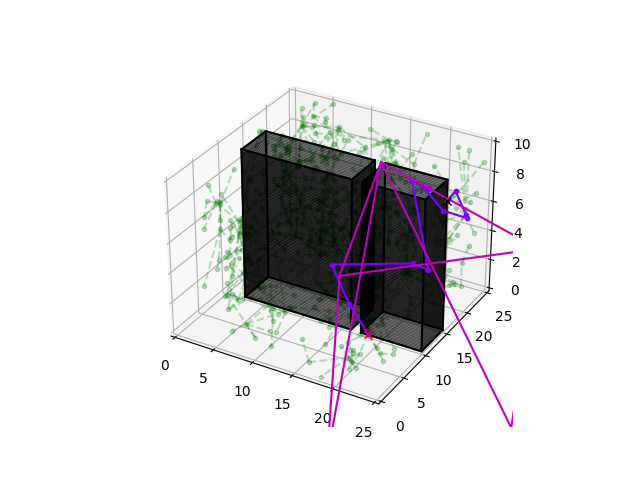

In [8]:
# Visualization

%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot node
for v in V:
    ax.plot3D(v[0], v[1], v[2], '.g', alpha=0.25)

# Plot edges
for ll in range(len(E)):
    edge1 = E[ll][0]
    edge2 = E[ll][1]
    ax.plot3D([edge1[0], edge2[0]], [edge1[1], edge2[1]], [edge1[2], edge2[2]], '--g', alpha=0.25)

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    bz = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
            bz.append(building[str(nb)]['height'])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
            bz.append(building[str(nb)]['height'])
    for ii in np.linspace(0, building[str(nb)]['height'], 100):
        ax.plot3D(bx, by, np.array([ii, ii, ii, ii, ii]), '-k', alpha=0.5)    
    ax.plot3D(bx, by, bz, '-k')
    ax.plot3D(bx, by, np.zeros(len(b)+1,), '-k')
    
    for i in range(len(b)):
        ax.plot3D([bx[i], bx[i]], [by[i], by[i]], [0, building[str(nb)]['height']], '-k')

# Path
color = iter(cm.rainbow(np.linspace(0, 1, len(path))))
#color = ['r', 'b', 'g']
for path_counter in range(len(path)):
    #print(str(path_counter))
    computed_path = path[str(path_counter)]
    #print(computed_path)
    c = next(color)
    for i in range(len(computed_path)-1):
        #ax.plot3D([computed_path[i][0], computed_path[i+1][0]], [computed_path[i][1], computed_path[i+1][1]], [computed_path[i][2], computed_path[i+1][2]], '-', c=color[path_counter], label="line "+str(path_counter))
        ax.plot3D([computed_path[i][0], computed_path[i+1][0]], [computed_path[i][1], computed_path[i+1][1]], [computed_path[i][2], computed_path[i+1][2]], '-', c=c, label="line "+str(path_counter))


    for p in computed_path:
        #ax.plot3D(p[0], p[1], p[2], '.', c=color[path_counter])
        ax.plot3D(p[0], p[1], p[2], '.', c=c)


camera_vertex = cam0.get_vertex(T[-1])
for i in range(4):
    temp = camera_vertex[str(i)]
    
    if i == 3:
        tempt = camera_vertex[str(0)]
    else:
        tempt = camera_vertex[str(i+1)]
    ax.plot3D([cam_pos[0], temp[0][0]], [cam_pos[1], temp[1][0]], [cam_pos[2], temp[2][0]], '-m')
    ax.plot3D([temp[0][0], tempt[0][0]], [temp[1][0], tempt[1][0]], [temp[2][0], tempt[2][0]], '-m')

ax.plot3D(x0[0], x0[1], x0[2], 'xr')
ax.plot3D(xf[0], xf[1], xf[2], 'xk')
ax.set_xlim(map_size[0], map_size[1])
ax.set_ylim(map_size[2], map_size[3])
ax.set_zlim(map_size[4], map_size[5])

In [9]:
print(len(this_path))
print(this_path)
print(len(this_path_time))
print(this_path_time) # (waittime, timestamp)
adfasf

13
[array([22.5, 20. ,  7. ]), array([22.7827353 , 21.54829773,  7.29167216]), array([23.9658129 , 21.94055347,  5.79199137]), array([24.28940914, 21.45693795,  5.73813605]), array([23.72447238, 16.73392283,  7.37414678]), array([21.43463746, 16.34919405,  8.69350932]), array([21.8318842 , 17.02619075,  8.50450349]), array([19.19157489, 18.08073396,  8.32466854]), array([20.22891731, 20.51821515,  1.80355623]), array([17.74421878, 21.45584879,  1.60867503]), array([16.28574098,  5.64279491,  5.64545785]), array([19.78202527,  3.23663767,  4.30052009]), array([22.5,  2.5,  3. ])]
13
[(1.407337739519971, 1696.5295519007896), (0.0, 632.3774217502897), (0.0, 537.5019694343544), (0.0, 536.5363472652405), (0.909926822638207, 70.41217326890259), (0.0, 68.75582607151779), (0.0, 68.02459219871548), (0.0, 66.047107297156), (0.0, 64.10680801518944), (0.0, 60.297190482722655), (0.0, 3.178077435819705), (0.0, 2.058666371884783), (0.0, 0.0)]


NameError: name 'adfasf' is not defined

In [ ]:
# Build Animation
from matplotlib.animation import FuncAnimation
 
fig = plt.figure()
ax = plt.axes(projection='3d')

def animation_function(kk):
    ax.clear()
    ax.plot3D(x0[0], x0[1], x0[2], 'xr')
    ax.plot3D(xf[0], xf[1], xf[2], 'xb')
    
    for nb in range(building['nb']):
        b = building[str(nb)]['Polygon']
        bx = []
        by = []
        bz = []
        for i in range(len(b)+1):
            if i < len(b):
                bx.append(b[i][0])
                by.append(b[i][1])
                bz.append(building[str(nb)]['height'])
            else:
                bx.append(b[i-len(b)][0])
                by.append(b[i-len(b)][1])
                bz.append(building[str(nb)]['height'])
        for ii in np.linspace(0, building[str(nb)]['height'], 100):
            ax.plot3D(bx, by, np.array([ii, ii, ii, ii, ii]), '-k', alpha=0.5)    
        ax.plot3D(bx, by, bz, '-k')
        ax.plot3D(bx, by, np.zeros(len(b)+1,), '-k')
        
        for i in range(len(b)):
            ax.plot3D([bx[i], bx[i]], [by[i], by[i]], [0, building[str(nb)]['height']], '-k')

    camera_vertex = cam0.get_vertex(kk)
    for ii in range(4):
        temp = camera_vertex[str(ii)]
        
        if ii == 3:
            tempt = camera_vertex[str(0)]
        else:
            tempt = camera_vertex[str(ii+1)]
        ax.plot3D([cam_pos[0], temp[0][0]], [cam_pos[1], temp[1][0]], [cam_pos[2], temp[2][0]], '-m')
        ax.plot3D([temp[0][0], tempt[0][0]], [temp[1][0], tempt[1][0]], [temp[2][0], tempt[2][0]], '-m')

    #plot vertex
    currentTimeStamp = min(range(len(this_path_time)), key=lambda j: abs(this_path_time[j]-kk))
    for path_counter in range(len(path)):
        computed_path = path[str(path_counter)]
        for i in range(currentTimeStamp):
            print(i)
            # Plot Vertex
            ax.plot3D(computed_path[i][0], computed_path[i][1], computed_path[i][2], '-r')
     

    ax.set_xlim(map_size[0], map_size[1])
    ax.set_ylim(map_size[2], map_size[3])
    ax.set_zlim(map_size[4], map_size[5])
 
animation = FuncAnimation(fig,
                          func = animation_function,
                          frames = np.arange(0, 100, 0.5),
                          interval = 10)

animation.save("test.mp4")
#plt.show()